# Calculate averaged surface temperature and precipitation anomalies

Goals:
- Compute the averaged surface temperature anomaly and the same for precipitation anomaly over the period 2081-2100 compared to the period 1981-2000
- Display delta-T delta-P diagram

The example calculates the averaged temperature anomaly (using the **TG**) indicator) vs the precipitation anomaly (using the **PRCPTOT** indicator) for the period 2081-2100 compared to the reference 1981-2000 for SSP 585 and several climate models.

We assume to have the **tas** and the **pr** variables in netCDF files in a `./data` folder.
The data can be dowloaded using the [metalink](data/cmcc_gfdl_pr_and_tas.metalink) provided with this notebook.
The data described in a `.metalink` file can be dowloaded with tools such as [aria2](https://aria2.github.io/) or a browser plugin such as [DownThemAll!](https://addons.mozilla.org/en-US/firefox/addon/downthemall/)
If you wish to use a different dataset, you can use the [climate 4 impact portal](https://www.climate4impact.eu/c4i-frontend/) to search and select the data you wish to use and a metalink file to the [ESGF](https://esgf.llnl.gov/) data will be provided.


The data is read using xarray and a plot of the a deltaT-deltaP diagram with data averaged over Europe is generated.

The datasets that are expected for this notebook are tas and pr parameters (needed to calculate the TG and PRCPTOT indicators respectively) for several climate models, for the historical (1981-2000) and future (2081-2100) SSP 585 experiment and for several climate models and one member. Daily data is used. In C4I, you can find all of the data needed in the CMIP6 project, at the **esgf-data3.ceda.ac.uk** and **esgf.nci.org.au** mirrors.

### Preparation of the modules

In [1]:
%pip install icclim matplotlib nc_time_axis

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime
import sys
from pathlib import Path

import cftime
import icclim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

print("python: ", sys.version)
print("numpy: ", np.__version__)
print("xarray: ", xr.__version__)
print("pandas: ", pd.__version__)
print("icclim: ", icclim.__version__)
print("cftime: ", cftime.__version__)

python:  3.11.7 | packaged by conda-forge | (main, Dec 15 2023, 08:38:37) [GCC 12.3.0]
numpy:  1.26.2
xarray:  2023.10.1
pandas:  2.1.4
icclim:  6.6.0
cftime:  1.6.3


### Parameters Setup  
The time period of interest as well as the reference period are defined here.
A list of models is listed here as an example.
Here we used Monthly data (Amon) but daily data could also be used.
The corresponding datafiles must have been selected by the user, containing both the studied and referenced periods.

In [6]:
# studied period
yearb = 2081
yeare = 2100
dt1 = datetime.datetime(yearb, 1, 1, tzinfo=datetime.timezone.utc)
dt2 = datetime.datetime(yeare, 12, 31, tzinfo=datetime.timezone.utc)

# reference period
yearrefb = 1981
yearrefe = 2000
dtr1 = datetime.datetime(yearrefb, 1, 1, tzinfo=datetime.timezone.utc)
dtr2 = datetime.datetime(yearrefe, 12, 31, tzinfo=datetime.timezone.utc)

# studied domain
# Western Europe
minlat = 30
maxlat = 56
minlon = -30
maxlon = 30

models = ["CMCC-ESM2", "GFDL-ESM4"]
out_f = {}
out_hist_f = {}
out_f_pr = {}
out_hist_f_pr = {}
for model in models:
    out_f[model] = f"data/dtdp_tg_icclim_{model}.nc"
    out_hist_f[model] = f"data/dtdp_tg_icclim_{model}_hist.nc"
    out_f_pr[model] = f"data/dtdp_pr_icclim_{model}.nc"
    out_hist_f_pr[model] = f"data/dtdp_pr_icclim_{model}_hist.nc"
    data_dir = Path("data")
    filenames_hist = data_dir.glob(f"tas_day_{model}_historical_*.nc")
    filenames_585 = data_dir.glob(f"tas_day_{model}_ssp585_*.nc")
    filenames_hist_pr = data_dir.glob(f"pr_day_{model}_historical_*.nc")
    filenames_585_pr = data_dir.glob(f"pr_day_{model}_ssp585_*.nc")

icclim is then executed for both periods for each climate model separately.

In [ ]:
for model in models:
    icclim.index(
        index_name="TG",
        in_files=[str(f) for f in filenames_585],
        var_name="tas",
        slice_mode="year",
        time_range=[dt1, dt2],
        out_file=out_f[model],
        logs_verbosity="LOW",
    )
    icclim.index(
        index_name="TG",
        in_files=[str(f) for f in filenames_hist],
        var_name="tas",
        slice_mode="year",
        time_range=[dtr1, dtr2],
        out_file=out_hist_f[model],
        logs_verbosity="LOW",
    )
    icclim.index(
        index_name="PRCPTOT",
        in_files=[str(f) for f in filenames_585_pr],
        var_name="pr",
        slice_mode="year",
        time_range=[dt1, dt2],
        out_file=out_f_pr[model],
        logs_verbosity="LOW",
    )
    icclim.index(
        index_name="PRCPTOT",
        in_files=[str(f) for f in filenames_hist_pr],
        var_name="pr",
        slice_mode="year",
        time_range=[dtr1, dtr2],
        out_file=out_hist_f_pr[model],
        logs_verbosity="LOW",
    )

print("Processing finished.")

### Data preparation

Here all data is loaded in 2 separate variables, one containing all the historical periods for all the models, and the same for the future time period.

Extract geographical domain and deal with longitudes

In [8]:
# Open datasets
tg = []
tg_hist = []
pr = []
pr_hist = []
for model in models:
    dsl = xr.open_dataset(out_f[model], decode_times=False)
    dsl["time"] = xr.decode_cf(dsl).time
    dsl = dsl.assign_coords({"model_id": model})

    dslp = xr.open_dataset(out_f_pr[model], decode_times=False)
    dslp["time"] = xr.decode_cf(dslp).time
    dslp = dslp.assign_coords({"model_id": model})

    dshl = xr.open_dataset(out_hist_f[model], decode_times=False)
    dshl["time"] = xr.decode_cf(dshl).time
    dshl = dshl.assign_coords({"model_id": model})

    dshlp = xr.open_dataset(out_hist_f_pr[model], decode_times=False)
    dshlp["time"] = xr.decode_cf(dshlp).time
    dshlp = dshlp.assign_coords({"model_id": model})

    # Reorder longitudes if needed and extract domain
    if minlon > maxlon or minlon < 0:
        dsl = dsl.assign_coords(lon=(((dsl.lon + 180) % 360) - 180)).roll(
            lon=(dsl.dims["lon"] // 2), roll_coords=True
        )
        dslp = dslp.assign_coords(lon=(((dslp.lon + 180) % 360) - 180)).roll(
            lon=(dslp.dims["lon"] // 2), roll_coords=True
        )
        dshl = dshl.assign_coords(lon=(((dshl.lon + 180) % 360) - 180)).roll(
            lon=(dshl.dims["lon"] // 2), roll_coords=True
        )
        dshlp = dshlp.assign_coords(lon=(((dshlp.lon + 180) % 360) - 180)).roll(
            lon=(dshlp.dims["lon"] // 2), roll_coords=True
        )

        if minlon >= 180:
            minlon = minlon - 360
        if maxlon >= 180:
            maxlon = maxlon - 360

    dsl = dsl.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
    dslp = dslp.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
    dshl = dshl.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))
    dshlp = dshlp.sel(lon=slice(minlon, maxlon), lat=slice(minlat, maxlat))

    tg.append(dsl["TG"])
    pr.append(dslp["PRCPTOT"])
    tg_hist.append(dshl["TG"])
    pr_hist.append(dshlp["PRCPTOT"])

### Perform spatial average on the extracted geographical domain

In [9]:
# Average different grids
for ii in range(len(tg)):
    tg[ii] = tg[ii].mean(dim=["lon", "lat"])
for ii in range(len(pr)):
    pr[ii] = pr[ii].mean(dim=["lon", "lat"])
for ii in range(len(tg_hist)):
    tg_hist[ii] = tg_hist[ii].mean(dim=["lon", "lat"])
for ii in range(len(pr_hist)):
    pr_hist[ii] = pr_hist[ii].mean(dim=["lon", "lat"])

### Define a function to align all different calendar types

In [10]:
# Define function to align different calendars using annual data
def to_pandas_dt(da):
    """Takes an annual DataArray. Change the calendar to a pandas datetime."""
    val = da.copy()
    # val.resample(time='Y').mean('time')
    timev = []
    years = [int(val) for val in da.time.dt.strftime("%Y")]
    for itime in range(val.sizes["time"]):
        timev.append(years[itime])

    timevp = pd.to_datetime(timev, format="%Y")
    time1 = xr.DataArray(data=timevp, dims=["time"])
    time1.name = "time"
    # We rename the time dimension and coordinate to time360 to make it clear it isn't
    # the original time coordinate.
    val = val.rename({"time": "timepd"})
    time1 = time1.rename({"time": "timepd"})
    val = val.assign_coords({"timepd": time1})

    return val

### Align calendars of all input data

In [11]:
# Convert all calendars to annual precision (we have configured icclim to output yearly data)
ll = [to_pandas_dt(da) for da in tg]
llp = [to_pandas_dt(da) for da in pr]
ll_hist = [to_pandas_dt(da) for da in tg_hist]
llp_hist = [to_pandas_dt(da) for da in pr_hist]

# Concatenate all models into one
full_tg = xr.concat(ll, "model_id", join="outer")
full_pr = xr.concat(llp, "model_id", join="outer")
full_tg_hist = xr.concat(ll_hist, "model_id", join="outer")
full_pr_hist = xr.concat(llp_hist, "model_id", join="outer")
full_tg_anomaly = full_tg.mean(dim="timepd") - full_tg_hist.mean(dim="timepd")
full_pr_anomaly = (
    (full_pr.mean(dim="timepd") - full_pr_hist.mean(dim="timepd"))
    / full_pr.mean(dim="timepd")
    * 100.0
)

### Plot a multi-model scatter plot of the anomalies of temperature and precipitation of the future time period 2081-2100 SSP 585 compared to the historical period

Temperature and Precipitation anomalies for SSP585 of the period 2080-2100 vs 1981-2000.

Text(0.5, 0, 'Temperature Anomaly K')

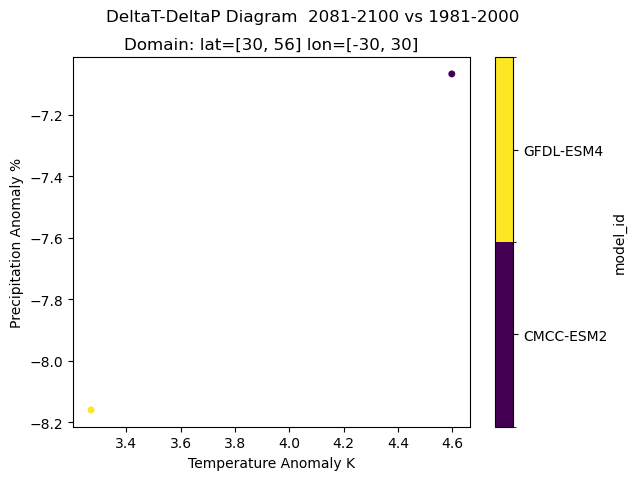

In [28]:
# Plot deltaT-deltaP diagram

# To use xarray scatter plot, create a new Dataset using both DataArrays
ds_anomaly = xr.Dataset({"TG": full_tg_anomaly, "PRCPTOT": full_pr_anomaly})

# Scatter Plot
xr.plot.scatter(ds_anomaly, x="TG", y="PRCPTOT", hue="model_id")
plt.suptitle(
    "DeltaT-DeltaP Diagram  "
    + str(yearb)
    + "-"
    + str(yeare)
    + " vs "
    + str(yearrefb)
    + "-"
    + str(yearrefe)
)
plt.title(
    "Domain: lat=["
    + str(minlat)
    + ", "
    + str(maxlat)
    + "] lon=["
    + str(minlon)
    + ", "
    + str(maxlon)
    + "]"
)
plt.ylabel("Precipitation Anomaly %")
plt.xlabel("Temperature Anomaly K")